# RESDOG-CNTK
## Dog breed identification via transfer learning in CNTK/Keras

## v. 0.0.1 
### Very much a work in progress!

---
This is a notebook, derived from an assignment completed as part of the [Udacity Deep Learning Nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101), in which we develop a dog breed classifier using transfer learning, starting with a pre-trained (on ImageNet) [ResNet-50](https://arxiv.org/abs/1512.03385) and then modifying it for our task, re-training only the new fully-connected layer(s). This is done entirely locally using [Microsoft's CNTK](https://github.com/Microsoft/CNTK) 2.4, via [Keras](https://github.com/keras-team/keras), with CUDA 9.0 and cudNN 7 running on one GTX 1080Ti, on Windows 10. Please see the README `##TODO: add README` for more details and instructions concerning environment and preparing yours.

This is followed by some brief experimentation with:

1. Deciding what breed of dog a human most resembles
2. Deliberately difficult/adversarial example(s)

using user-supplied images.

I have modified the notebook significantly to remove portions not of direct relevance to anyone but students taking the assignment, but have most of the original steps and other aspects of the assignment for pedagogical value in motivating the use of CNNs and transfer learning in image classification, and because there are areas where I intend to improve upon what was provided by the instructors. This includes the "conceptual" questions posed by the instructors and my (sadly hastily-and- caffeine-deprived-written) answers for the same reason. You will probably notice several optimizations that can be made or areas where performance is poor. That is the idea; this notebook and repository will track my continued tweaking of the original assignment. For tasks currently on the to-do list, see the README.

I have also unsurprisingly redacted elements of e.g. the specific paths on my local machine involved.

![Sample Dog Output](images/sample_dog_output.png)

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

C:\Users\Philo\Anaconda3\envs\dog-project-cntk\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using CNTK backend


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


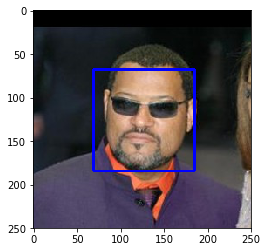

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
# TODO: Completely rework this to return more data than just a boolean, particularly positional
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

import collections 

human_performance = collections.Counter()
dog_performance = collections.Counter()

for i in range(len(human_files_short)):
     if face_detector(human_files_short[i]):
        human_performance[i] += 1

        
for i in range(len(dog_files_short)):
    if face_detector(dog_files_short[i]):
        dog_performance[i] += 1

print(sum(human_performance.values()), "% of humans correctly detected")        
print(sum(dog_performance.values()), "% of dogs misidentified as humans")

99 % of humans correctly detected
11 % of dogs misidentified as humans


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ I'm going to answer with a fairly unhelpful "it depends." Namely, it depends on the broader purpose of the system we're building. If, for example, we are building a system that assesses peoples' facial features in various ways (say to measure facial structure similarity between two individuals), then it is perfectly reasonable to require a clear view of the face. For a "low tech" analogy, consider driver's license/passport photos.

On the other hand, if we are building a system where detecting whether a human face is present anywhere in the image (and maybe even other things about it, like some of its characteristics or location as best we can), then this is not a reasonable demand and we need a more sophisticated detector. Consider something like a system that processes video/image data from aircraft doing a flyover of an area. The human faces on the ground may be very small, out of focus, in the corner etc., but it is important that they are there. 

Two potential applications might be search and rescue (flyovers of large areas of, say, ocean or wilderness areas, with potentially superior "spotting" to a human, and potentially allowing larger areas to be covered more quickly by increasing speed, altitude etc., given sufficient image resolution) or studying/checking up on the welfare of the so-called "uncontacted" tribes in the Amazon, where the main methodology of the Brazilian government, for example, is currently to fly over with a plane at relatively low altitude and have a human spotter look for people in clearings and other open areas. This could potentially be improved if the face detector is superior to a human spotter, and could even mean that relatively small, quiet, and therefore less intrusive drones could be deployed to the task rather than expensive and disruptive manned aircraft flying at low altitude.

Or, in a darker but necessary vein, consider surveillance systems, or targeting systems for military applications, whether in the case of human-assistance (say, augmented reality scopes or goggles for soldiers to assist in targeting enemy combatants) or fully autonomous warfighting robots. Although some of these applications may be more suited to RNNs w/ LSTM in practice, this should motivate the context-dependency of certain design choices.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [13]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

As we are using CNTK rather than TensorFlow, the specific following transformations need not be strictly the same, but we ended up using this same data transformation anyway, for conceptual clarity and compatibility. When using TensorFlow as backend, Keras CNNs require a 4D array 4D tensor as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively. 

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [14]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [15]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
### TODO: Maybe rework this
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [17]:
human_performance.clear()
dog_performance.clear()

for i in range(len(human_files_short)):
     if dog_detector(human_files_short[i]):
        human_performance[i] += 1

        
for i in range(len(dog_files_short)):
    if dog_detector(dog_files_short[i]):
        dog_performance[i] += 1

print(sum(human_performance.values()), "% of humans misidentified as dogs")        
print(sum(dog_performance.values()), "% of dogs correctly identified")

1 % of humans misidentified as dogs
100 % of dogs correctly identified


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we create a CNN that classifies dog breeds.  This CNN is created _from scratch_ (no transfer learning _yet_!), and the goal was to attain test accuracy of at least 1%.SS

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [18]:
from PIL import ImageFile
from keras.preprocessing.image import ImageDataGenerator
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████| 836/836 [00:07<00:00, 105.59it/s]


### Model Architecture

Here we create a simple CNN from scratch to classify dog breed. In case we ended up getting stuck, we were provided a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I began by trying out something along the lines of the hinted architecture just to get a baseline. It's a good start to an image classification task like this one as the network is reasonably deep, so can extract decently high-level abstractions from the images it sees, while also reducing overfitting (regularizing) fairly well by providing a pooling layer for each convolution layer, which also has the beneficial effect of keeping the number of model parameters under control as poolings are essentially summary statistics.

However, I wanted to do something a little different, and to be honest to play around with the GPU capabilities of my backend, so I returned to the general idea of an architecture I had a great deal of success with in one of the mini-projects during the CNN lessons, where I stacked 2 convolution layers on top of each other before pooling. In that example, I followed this with a series of fully connected layers with dropout to keep the number of parameters under control, before the final softmax activation.

The data in that case was quite manageable with said architecture, but with the present dataset and problem structure it would not have been remotely feasible to train the network with my time and computational resources, in part due to an explosion in the number of parameters. I therefore went for the same "spirit" while trying to keep the number of parameters under control, and have it work decently with relatively few epochs.

The main source of the parameter explosion was the use of multiple fully-connected layers prior to the final layer (one architecture I drew up had about 800 million parameters), so I eliminated those. Then I stopped to reflect on more general principles. 

Regardless of what type of machine learning task we're talking about, we want (within our computational and time constraints) good training fit without *over*fitting. In general, a bigger (deeper, more parameters etc.) network will probably, given enough time, get better training fit. But since what we want is good performance on new, future data (test performance), as well as reasonable computational tractability given our resources, we must regularize in some fashion. While there are numerous details of how we do this of course, fundamentally one can think of there being only two big knobs that we can tune to get the best performance out of our model; model fit (training fit) and regularization (corrects for overfitting). We just tweak these knobs until we find a good balance for our purposes given our constraints.

In this case, I decided to compensate for the loss of the fully connected layers by stacking three, rather than two, of my conv-conv-pool stacks on top of one another, simply doubling the filter size with each successful "hyperlayer" as we might call it, and keeping the other main convolution parameters relatively simple, with the pool and kernel sizes simply being the number of color channels, and using a stride of 1. This did better, but had some overfitting problems, which I decided to tackle next.

Originally during the assignment I went with only 3 epochs, which did achieve the goal, but is too low to be really useful. This was because of a very corner-case VRAM memory-leak issue I had with cudNN which has since been resolved.

Then it was a matter of regularizing and choosing the learning rate. I went with 0.1 for the latter since 1) it's a good baseline and 2) I was empirically getting the best results for learning rates $r$ with $0 \leq r \leq 1$. It could probably be tuned better, since the learning rate is the only hyperparameter which has an optimal value (even if we can never exactly find it), but this was just an exercise so I did not want to waste time over-optimizing. In terms of other regularization, adding dropouts after each "hyperlayer" worked quite well. I also added a small learning rate decay.

Finally, I decided to use SGD with momentum (specifically Nesterov momentum) rather than rmsprop for my optimization method. I make no claim that this necessarily would have been optimal, but I had good luck using SGD with momentum for CNNs in image-related tasks so far, and wanted to try Nesterov momentum as I had been reading about the underlying mathematics of momentum and wanted to try the Nesterov method, and it turned out to work better. Finally, I used `valid` rather than `same` padding simply because cudNN on Windows sometimes complains and goes into a slow fallback mode if `same` is used under certain circumstances. (Note: This might be a bug or config issue. Investigate further) It was just a sanity-preserving measure.

In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(input_shape=(224, 224, 3),filters=16, kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='valid'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='valid'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='valid'))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(units=133,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 218, 218, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 218, 218, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 216, 216, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 214, 214, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 212, 212, 32)      0         
__________

### Compile the Model

In [20]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [21]:
from keras.callbacks import ModelCheckpoint  

### Specify the number of epochs that you would like to use to train the model
### Note that when I initially did the assignment, I had a very corner-case VRAM memory-leak issue with cudNN, which
### made the training performance very poor. This has since been resolved.

epochs = 10


### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10


C:\Users\Philo\Anaconda3\envs\dog-project-cntk\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input30809") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


6680/6680 [==============================] - ETA: 4:30 - loss: 4.8857 - acc: 0.0000e+00 - ETA: 8:31 - loss: 4.8905 - acc: 0.0000e+00 - ETA: 6:20 - loss: 4.8870 - acc: 0.0000e+00 - ETA: 5:14 - loss: 4.8861 - acc: 0.0000e+00 - ETA: 4:35 - loss: 4.8841 - acc: 0.0000e+00 - ETA: 4:09 - loss: 4.8842 - acc: 0.0000e+00 - ETA: 3:49 - loss: 4.8846 - acc: 0.0000e+00 - ETA: 3:35 - loss: 4.8863 - acc:

### Load the Model with the Best Validation Loss

In [22]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%. Recall that random guessing would yield about 0.7%.

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.1531%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, the instructors showed us how to train a CNN using transfer learning.  In the following step, we take a guided tour through a transfer learning example using [VGG16](https://arxiv.org/abs/1409.1556).

### Obtain Bottleneck Features

In [24]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [25]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [26]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20


C:\Users\Philo\Anaconda3\envs\dog-project-cntk\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input31935") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


6680/6680 [==============================] - ETA: 7s - loss: 13.3230 - acc: 0.1000 - ETA: 3s - loss: 14.9751 - acc: 0.0313 - ETA: 2s - loss: 14.8857 - acc: 0.0300 - ETA: 2s - loss: 14.7502 - acc: 0.0273 - ETA: 2s - loss: 14.5646 - acc: 0.0259 - ETA: 2s - loss: 14.5095 - acc: 0.0314 - ETA: 2s - loss: 14.3879 - acc: 0.0341 - ETA: 2s - loss: 14.2531 - acc: 0.0319

### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.9234%


### Predict Dog Breed with the Model

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: RESDOG

This is where we actually create and implement RESDOG, just a transfer-learning CNN created from ResNet-50 pre-trained on ImageNet. The goal of the assignment was to achieve at least 60% test accuracy. Our best result so far is 84.7%.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we use the bottleneck features from a different pre-trained model.  To make things easier for us, the instructors pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

###  Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [28]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

###  Model Architecture

Here we create the CNN to classify dog breed.
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The first question was which existing network to use for the transfer learning? I chose ResNet-50 for muiltiple reasons. First it was a pioneering winner in the ImageNet competition. Second its use of an extremely large (at the time) number of relatively simple convolution layers stacked on top of one another is an intriguing methodology to me (and had some shared intuition with the "raw" network I created from scratch earlier), and the network depth meant that perhaps most of the challenge on my end would lie in regularization by various means to present overfitting, rather than training performance. 

Third, and perhaps most importantly, I suspected the architecture as originally described in [He et al. 2015](https://arxiv.org/abs/1512.03385) would be relatively easy to adapt to this transfer learning case, for as table 1 in the aforementioned paper shows, the "end" of the model is simply an average pooling layer, a dense layer, and then softmax activation. Since our dog breed prediction task deals with a similar problem structure and dataset to the ImageNet competition, but vastly simpler and smaller, a good method - as we learned in the lessons - is simply to chop off the end of the original network, add a new dense layer tailored to the number of classes in our dataset (133), freeze the weights from the original network (effectively already done for us in obtaining the bottleneck features), and retrain only our new layer. The structure of the original ResNet-50 meant that the below code, adding an appropriately defined GAP layer and then a dense layer with softmax activation, essentially resulted in a "drop-in" replacement for the original. 

Then it was just a matter of regularizing and tuning the optimizer (which I could have done much more systematically, but for lack of time, although semi-systematic testing found that I consistently got the best results, even randomly varying other hyperparameters like the learning rate, from the Adam and SGD-Nesterov optimizers. I went with the latter because it's more intuitive to me and it's making SGD cool again).

Finally, although this is a somewhat petty reason, ResNet50 famously came out of Microsoft Research Asia, and I'm personally interested in all things Microsoft.

In [29]:
### Defines the modifications to the ResNet-50 architecture as a model.
RESDOG = Sequential()
RESDOG.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
RESDOG.add(Dense(133,activation='softmax'))
RESDOG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [30]:
### TODO: Proper, more extensive hyperparameter tuning. Currently only a very rough random search was performed for the 
### learning rate. In the future I may implement evolutionary/genetic hyperparameter tuning.

sgd = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7, nesterov=True)

RESDOG.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### Train the Model

Train the model in the code cell below.  We use model checkpointing to save the model that attains the best validation loss.  

__TODO__: Augment data

In [31]:
### Trains the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

RESDOG.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20


C:\Users\Philo\Anaconda3\envs\dog-project-cntk\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input32363") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


6680/6680 [==============================] - ETA: 8s - loss: 5.5249 - acc: 0.0000e+00 - ETA: 2s - loss: 5.3930 - acc: 0.0227     - ETA: 2s - loss: 5.3195 - acc: 0.0225 - ETA: 1s - loss: 5.2072 - acc: 0.0300 - ETA: 1s - loss: 5.1367 - acc: 0.0368 - ETA: 1s - loss: 5.0262 - acc: 0.0447 - ETA: 1s - loss: 4.9215 - acc: 0.0589 - ETA: 1s - loss: 4.8101 - acc: 0.0682

### Load the Model with the Best Validation Loss

In [34]:
RESDOG.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

Here we test the model, with the original assignment being to achieve over 60% test accuracy.

In [35]:
### Calculates classification accuracy on the test dataset.
# gets index of predicted dog breed for each image in test set
RESDOG_predictions = [np.argmax(RESDOG.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# reports test accuracy
test_accuracy = 100*np.sum(np.array(RESDOG_predictions)==np.argmax(test_targets, axis=1))/len(RESDOG_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.0144%


###  Predict Dog Breed with the Model

Here we wrote a simple function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by the model.  

We were instructed to, similarly to the analogous function in Step 5, :
1. Extract the bottleneck features corresponding to ResNet-50.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.

In [36]:
### Takes a path to an image as input and returns the dog breed that is predicted by the model.

def RESDOG_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = RESDOG.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Here we wrote a simple algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,

- if a __dog__ is detected in the image, returns the predicted breed.
- if a __human__ is detected in the image, returns the resembling dog breed.
- if __neither__ is detected in the image, provides output that indicates an error.

### Write your Algorithm

In [37]:
### TODO: Rewrite with better detectors. This is very basic and performs somewhat poorly for reasons described in the discussion 
### in step 7. Needs more sophisticate detection.

#Image path must be manually specified. See example in Step 7.

def RESDOG_2_Electricic_Boogaloo(img_path):

    breed = RESDOG_predict_breed(img_path)

    is_dog = dog_detector(img_path)

    if is_dog:
        print("Hmmm, this kinda looks like a ", breed, " to me, though I'm not sure.")

    else:
        is_human = face_detector(img_path)
    
        if is_human:
            print("Hello human, if you were a dog I feel like you'd be a ", breed)
        
        else:
            print("すみません, I couldn't quite make out what this image is. Please try again. (●´ω｀●)ゞ.")




---
<a id='step7'></a>
## Step 7: Test Your Algorithm

### Test Your Algorithm on Sample Images!

We were instructed to use at least 6 of our own test images, with at least two human and two dog pictures. The algorithm performed adequately, but not particularly well. Feel free to use any images you like.

To play with this yourself, just specify an image path.

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ Performance was worse than one would expect based on the test performance of the model, but this was not surprising to me. First and most importantly, the dog dataset (if one takes time to browse through the images) is relatively clean; the dogs are clearly the primary subject, take up most of the photo, are in focus, etc. I had a friend who is also in computer science (specializing in application and operating system engineering, and UX/human-computer interaction) choose the test images for me, and got slightly more challenging images; the dog images are simply not as good as in the dataset (sharpness, focus, position, angle of the dog in the picture, etc.) and a deliberately "adversarial" example was also provided containing both a human and a cat, with the human out-of-focus and off center with the cat front and center. The algorithm did not correctly realize there was a human in this image. To its credit, the algorithm did realize that and image of a deer fawn with an opposum on its back was *not* a dog, despite the abstract structural similarities of the two animals (four legged mammals with similar body layout).

In terms of improvements I would make, beyond simply fine-tuning optimizers and performing a proper hyperparamter search, I simply used the existing dog/human detector functions. While openCV using Haar cascades can certainly locate the position of a face in an image, as we saw near the beginning of this notebook, the detection functions themselves are simply booleans; they say "there is(not) a dog" and "there is(not) a human face," with no regard for *where* in the image either of these things are. RESDOG, which predicts breed, therefore just does its best with the whole image as-is, which with lesser-quality input data results unsurprisingly in worse predictions. If I was to put more time into this to improve its performance, I would therefore use face/dog detection that attempts to locate the subject, and then possibly transforms the image accordingly before passing it to the CNN.

Relatedly, regarding the adversarial example, I might replace the supplied face detection method with a more sophisticated one, e.g. one able to detect out-of-focus faces, or faces where the face is not the primary subject.

This segues naturally into probably biggest improvement I'd make, which is to augment the training data (basically further regularization), as the problems described above can in a sense be attributed to insufficient invariance (invariance to the dog's position, orientation etc.). I've had particularly good luck in other examples I've been playing with using random shears, flips, and zooms. I'm also a fan of jitters/random crops, but don't know how to do those in Keras as opposed to raw CNTK. Alas life simply got in the way and I did not have a change to implement the augmentation. I really wish I had been able to do this, and will probably do so even after the project has been officially submitted.

In [48]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

#Feel free to substititute your own images here. Lazy methodology, I know.
RESDOG_2_Electricic_Boogaloo('C:\\Path\\To\\Img.png')


Hmmm, this kinda looks like a  Lowchen  to me, though I'm not sure.
Hmmm, this kinda looks like a  Icelandic_sheepdog  to me, though I'm not sure.
Hmmm, this kinda looks like a  Norfolk_terrier  to me, though I'm not sure.
Hello human, if you were a dog I feel like you'd be a  Chihuahua
Hello human, if you were a dog I feel like you'd be a  Chihuahua
すみません, I couldn't quite make out what this image is. Please try again. (●´ω｀●)ゞ.
すみません, I couldn't quite make out what this image is. Please try again. (●´ω｀●)ゞ.
